In [5]:
import faiss # make faiss available
import numpy as np
import json
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
image_paths=[]
with open("../image-files/geological_map.json", 'r', encoding='utf-8') as f:
    image_paths=json.load(f)
print(len(image_paths))

embedding = np.load("../encoders/geological_embed.npy")

29998


In [7]:
random_img_index=random.randint(0, len(image_paths)-1)
xq=embedding[random_img_index]
xb=embedding
print(xb.shape)
print(xq.shape)
xq=np.reshape(xq, (1, 576))
print(xq.shape)

(29998, 576)
(576,)
(1, 576)


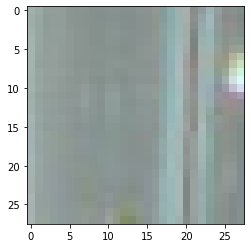

In [8]:
input_image_path=image_paths[random_img_index]
input_img = Image.open("../"+input_image_path).convert("RGB")
plt.imshow(input_img)
plt.show()

In [9]:
index = faiss.IndexFlatL2(576)# build the index
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print(index.ntotal)
k=10
Dist, Indices = index.search(xq, k)     # actual search
print(Indices)                   # neighbors of the 5 first queries


True
29998
[[26313 26235 28574 28306 25224 28615 26756 25118 28139 25573]]


total indices:  10
geological_similarity\schist\9IWAF.jpg


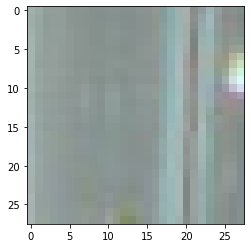

geological_similarity\schist\8Z0KT.jpg


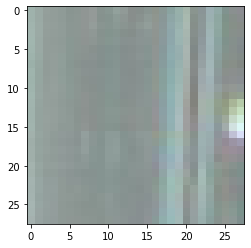

geological_similarity\schist\PQ6SU.jpg


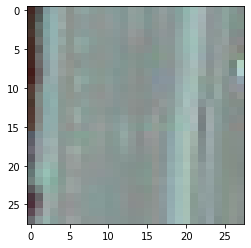

geological_similarity\schist\NS8QQ.jpg


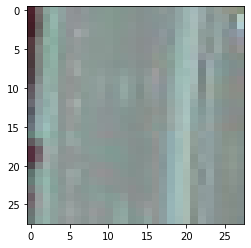

geological_similarity\schist\1O5FU.jpg


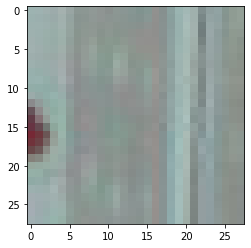

geological_similarity\schist\Q0GRD.jpg


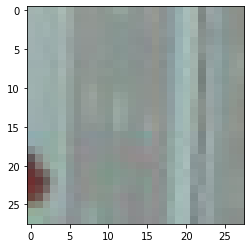

geological_similarity\schist\CRI56.jpg


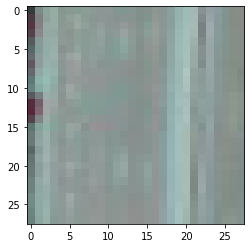

geological_similarity\schist\0VIY0.jpg


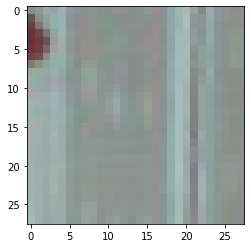

geological_similarity\schist\MNC9X.jpg


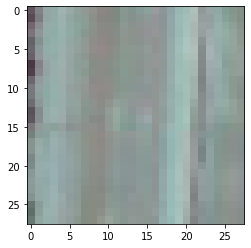

geological_similarity\schist\43KZC.jpg


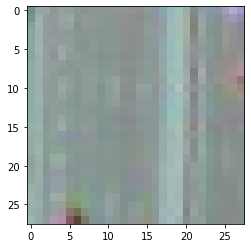

In [10]:
indices = Indices[0]
print("total indices: ", len(indices))
for index in indices:
    # img_name = str(index - 1) + ".jpg"
    # print(img_name)
    img_path = image_paths[index]
    print(img_path)
    img = Image.open("../"+img_path).convert("RGB")
    plt.imshow(img)
    plt.show()

In [14]:
#IVF-L2
import time
nlist = 100
k = 100
quantizer = faiss.IndexFlatL2(576)  # the other index
index = faiss.IndexIVFFlat(quantizer, 576, nlist, faiss.METRIC_L2)
# here we specify METRIC_L2, by default it performs inner-product search

assert not index.is_trained
index.train(xb)
assert index.is_trained

index.add(xb)                  # add may be a bit slower as well

start=time.time()
D, I = index.search(xq, k)     # actual search
# print(I[-5:])# neighbors of the 5 last queries
end=time.time()
print(end-start)
print(I)
index.nprobe = 10 # default nprobe is 1, try a few more
start=time.time()
D, I = index.search(xq, k)
end=time.time()
print(end-start)
print(I)                  # neighbors of the 5 last queries

0.005044698715209961
[[26313 26235 28574 28306 25224 28615 26756 25118 28139 25573 25026 27656
  29574 29630 25605 29776 27915 29976 29387 28770 26250 25661 25556 29512
  26828 27794 18314 26420 26151 17572 25813 15069 27225 16251 27435 27035
  16062 28332 27449 19584 27101 29116 26750 17325 29196 26277 28121 26097
  26593 19008 25295 15735 26402 27722 17073 28315 26528 29358 18683 18103
  25576 16726 15600 25244 26116 19468 29152 29443 26600 27841 28528 18347
  29794 29190 29252 29054 19344 28983 29406 26541 29137 25971 25780 29748
  28494 25788 27880 27299 28616 28301 28021 27583 28415 25037 25888 26924
  26133 19401 27289 29426]]
0.007173299789428711
[[26313 26235 28574 28306 25224 28615 26756 25118 28139 25573 25026 27656
  29574 29630 25605 29776 27915 29976 29387 28770 26250 25661 25556 29512
  26828 27794 18314 26420 26151 17572 25813 17511 15069 27225 16251 27435
  27035 16062 28332 27449 19584 27101 29116 26750 17325 29196 26277 28121
  26097 26593 19008 25295 15735 15166 2640

total indices:  10
geological_similarity\schist\9IWAF.jpg


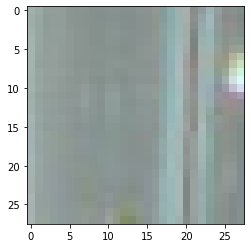

geological_similarity\schist\8Z0KT.jpg


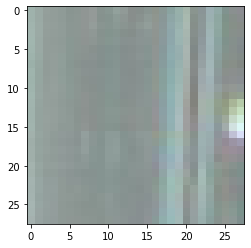

geological_similarity\schist\PQ6SU.jpg


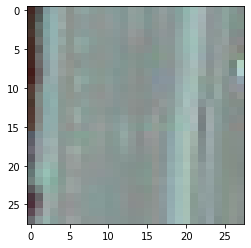

geological_similarity\schist\NS8QQ.jpg


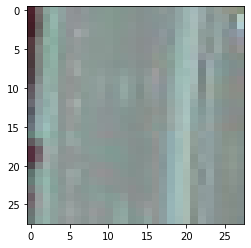

geological_similarity\schist\1O5FU.jpg


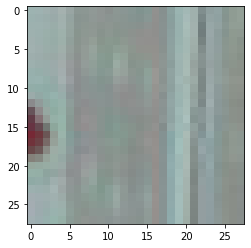

geological_similarity\schist\Q0GRD.jpg


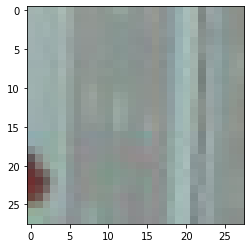

geological_similarity\schist\CRI56.jpg


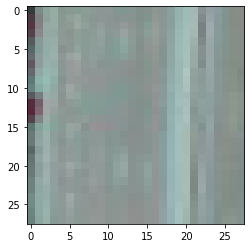

geological_similarity\schist\0VIY0.jpg


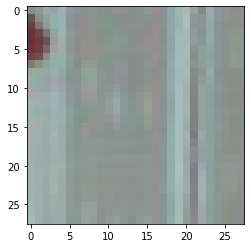

geological_similarity\schist\MNC9X.jpg


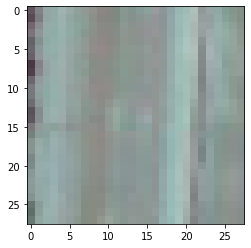

geological_similarity\schist\43KZC.jpg


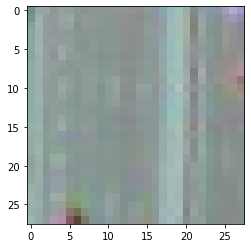

In [13]:
indices = I[0]
print("total indices: ", len(indices))
for index in indices:
    # img_name = str(index - 1) + ".jpg"
    # print(img_name)
    img_path = image_paths[index]
    print(img_path)
    img = Image.open("../"+img_path).convert("RGB")
    plt.imshow(img)
    plt.show()

In [13]:
#IVF Cosine

import faiss

nlist = 100
m = 8
k = 10
quantizer = faiss.IndexFlatL2(576)  # this remains the same
index = faiss.IndexIVFPQ(quantizer, 576, nlist, m, 8)
                                  # 8 specifies that each sub-vector is encoded as 8 bits
index.train(xb)
index.add(xb)
index.nprobe = 10              # make comparable with experiment above
D, I = index.search(xq, k)     # search
print(I[-5:])

[[23120 23551 21669 21582 24280 20424 22678 21972  1102 23247]]


total indices:  10
geological_similarity\rhyolite\M24QG.jpg


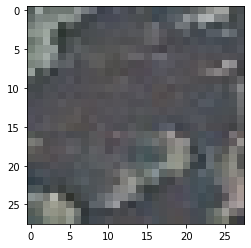

geological_similarity\rhyolite\P39YI.jpg


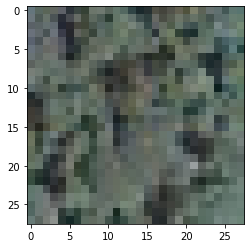

geological_similarity\rhyolite\BW6AD.jpg


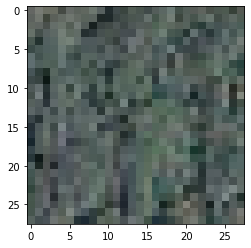

geological_similarity\rhyolite\BB35N.jpg


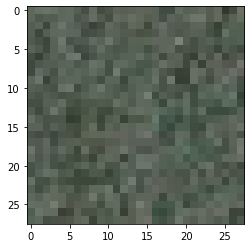

geological_similarity\rhyolite\UTM4G.jpg


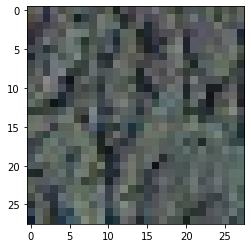

geological_similarity\rhyolite\2XWKV.jpg


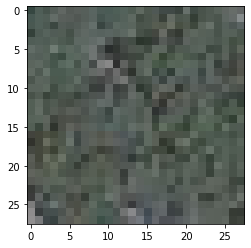

geological_similarity\rhyolite\J52R4.jpg


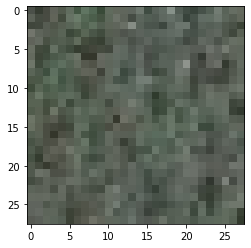

geological_similarity\rhyolite\E1YTE.jpg


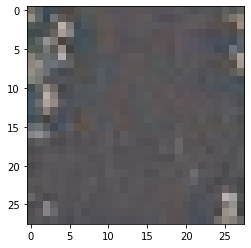

geological_similarity\andesite\81UIC.jpg


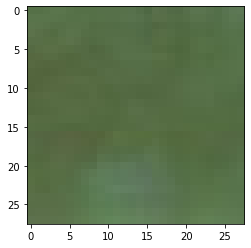

geological_similarity\rhyolite\MWNU8.jpg


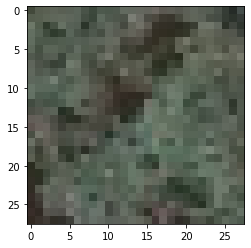

In [14]:
indices = I[0]
print("total indices: ", len(indices))
for index in indices:
    # img_name = str(index - 1) + ".jpg"
    # print(img_name)
    img_path = image_paths[index]
    print(img_path)
    img = Image.open("../"+img_path).convert("RGB")
    plt.imshow(img)
    plt.show()

In [22]:
import json
with open("../knn-results/euclidean_knn_results.json") as f:
    ground_truth=json.load(f)

print(ground_truth.keys())
    

dict_keys(['geological_similarity\\gneiss\\AUJMW.jpg', 'geological_similarity\\gneiss\\0UZPJ.jpg', 'geological_similarity\\andesite\\WKEYA.jpg', 'geological_similarity\\quartzite\\FB14S.jpg', 'geological_similarity\\marble\\8EOHS.jpg', 'geological_similarity\\andesite\\5FZWZ.jpg', 'geological_similarity\\marble\\5ZA3S.jpg', 'geological_similarity\\marble\\RBRPV.jpg', 'geological_similarity\\quartzite\\PKY1N.jpg', 'geological_similarity\\andesite\\SCEZG.jpg', 'geological_similarity\\marble\\A821W.jpg', 'geological_similarity\\gneiss\\8IBO6.jpg', 'geological_similarity\\gneiss\\NA7U1.jpg', 'geological_similarity\\gneiss\\YY47T.jpg', 'geological_similarity\\schist\\EDN6M.jpg', 'geological_similarity\\andesite\\AAIPV.jpg', 'geological_similarity\\quartzite\\7SYTR.jpg', 'geological_similarity\\schist\\YWYKY.jpg', 'geological_similarity\\andesite\\P6Y1E.jpg', 'geological_similarity\\andesite\\H7ZE0.jpg', 'geological_similarity\\rhyolite\\VOGN5.jpg', 'geological_similarity\\gneiss\\9SDOM.jpg'

In [24]:
import pandas as pd


In [38]:
df=pd.read_csv("../knn-results/jaccard-results.csv")
df.head()

,testing_image,time_taken,indices_list,output_indices
0,/Users/abhishekvaidyanathan/Downloads/geologic...,0.078578,NaN,"[25578, 25754, 29111, 29065, 26147, 29888, 252..."
1,/Users/abhishekvaidyanathan/Downloads/geologic...,0.052247,NaN,"[13641, 13191, 10152, 10489, 11181, 11653, 119..."
2,/Users/abhishekvaidyanathan/Downloads/geologic...,0.050436,NaN,"[17741, 2403, 4762, 149, 4965, 1685, 842, 1399..."
3,/Users/abhishekvaidyanathan/Downloads/geologic...,0.051299,NaN,"[9801, 9209, 6398, 6674, 9056, 7528, 7636, 813..."
4,/Users/abhishekvaidyanathan/Downloads/geologic...,0.051178,NaN,"[25855, 27277, 5806, 8640, 6559, 25850, 8451, ..."


In [39]:
for i in range(len(df["testing_image"])):
    df["testing_image"][i]=df["testing_image"][i].replace("/Users/abhishekvaidyanathan/Downloads", "..")
df.head()

<ipython-input-39-561f7451a125>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["testing_image"][i]=df["testing_image"][i].replace("/Users/abhishekvaidyanathan/Downloads", "..")


,testing_image,time_taken,indices_list,output_indices
0,../geological_similarity/schist/TEJ1Y.jpg,0.078578,NaN,"[25578, 25754, 29111, 29065, 26147, 29888, 252..."
1,../geological_similarity/marble/13P1E.jpg,0.052247,NaN,"[13641, 13191, 10152, 10489, 11181, 11653, 119..."
2,../geological_similarity/andesite/RRGXD.jpg,0.050436,NaN,"[17741, 2403, 4762, 149, 4965, 1685, 842, 1399..."
3,../geological_similarity/schist/PEVYX.jpg,0.051299,NaN,"[9801, 9209, 6398, 6674, 9056, 7528, 7636, 813..."
4,../geological_similarity/schist/66ZT7.jpg,0.051178,NaN,"[25855, 27277, 5806, 8640, 6559, 25850, 8451, ..."


In [40]:
df.to_csv("../knn-results/jaccard-results.csv", index=False)